In [1]:
import sys
sys.path.append("../..")
sys.path.append("../../..")

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, fisher_exact
import utility, importlib
from scipy.stats import spearmanr
import pingouin as pg
from scipy.stats import linregress
import warnings
import kaos
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)
pd.set_option('mode.chained_assignment', None)
import kaos
import pysam
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from scipy.stats import fisher_exact
from sklearn.metrics import confusion_matrix
# import utility
import importlib
pd.set_option('mode.chained_assignment', None)

from pdf2image import convert_from_path
from PIL import Image
from IPython.display import display
import kaos
import fcgr


In [3]:
kmer_length =10
fasta_file_path = "../../../data/GCF_000017985.1_ASM1798v1_genomic.fna"

In [4]:
def strip_whitespace_from_string_columns(input_df):
    """
    Returns a copy of the DataFrame with leading and trailing whitespace removed
    from all string/object columns.
    
    Args:
        input_df (pd.DataFrame): Input DataFrame to process.
    
    Returns:
        pd.DataFrame: Copy with whitespace stripped from all string columns.
    """
    cleaned_df = input_df.copy()
    for column in cleaned_df.select_dtypes(include=['object', 'string']):
        cleaned_df[column] = cleaned_df[column].str.strip()
    return cleaned_df

In [5]:
mutational_data_all_population = pd.read_csv("../../../data/LTEE_mutational_data.csv")
mutational_data_all_population = strip_whitespace_from_string_columns(mutational_data_all_population)


In [6]:
mutational_data_all_population.head(), mutational_data_all_population.shape

(        #CHROM  POS REF ALT population_label
 0  NC_012967.1   63   A   C               p6
 1  NC_012967.1  201   T   G               p6
 2  NC_012967.1  241   A   C               m1
 3  NC_012967.1  309   T   G               m1
 4  NC_012967.1  322   A   G               p3,
 (36922, 5))

In [7]:
class Oligo:
    @staticmethod
    def kgain(mutational_data: pd.DataFrame, fasta_file_path: str, fasta_string: str, kmer_length: int) -> pd.DataFrame:
        """
        Compute k-mer log-gain for mutations using frequency dictionary from a genome FASTA.

        Args:
            mutational_data (pd.DataFrame): DataFrame with '#CHROM', 'POS', 'REF', 'ALT' columns.
            fasta_file_path (str): Path to the genome FASTA file.
            kmer_length (int): Length of k-mers to use (e.g., 10).

        Returns:
            pd.DataFrame: Result table with mutation context and kGain.
        """
        import numpy as np
        import pandas as pd
        import pysam
        import kaos

        mutational_data = mutational_data.copy()
        mutational_data.reset_index(inplace=True, drop=True)
        required_cols = ['#CHROM', 'POS', 'REF', 'ALT']
        missing = [col for col in required_cols if col not in mutational_data.columns]
        if missing:
            raise ValueError(
                f"Input DataFrame is missing required column(s): {', '.join(missing)}.\n"
                f"Columns found: {list(mutational_data.columns)}"
            )
        # Check for duplicates
        n_duplicates = mutational_data.duplicated(subset=required_cols).sum()
        if n_duplicates > 0:
            print(f"[Warning] Found {n_duplicates} duplicate mutation(s) in input DataFrame (by {required_cols}). Duplicates will be dropped.")
            mutational_data = mutational_data.drop_duplicates(subset=required_cols).reset_index(drop=True)

        flank_size = kmer_length - 1
        genome = pysam.FastaFile(fasta_file_path)
        
        fcgr_dict = kaos.chaos_frequency_dictionary(
            fasta_string=fasta_string,
            kmer_length=kmer_length,
            pseudo_count=True,
            chaos_game_kmer_array=kaos.chaos_game_representation_key(kmer_length=kmer_length)
        )
        # Strip whitespace from all non-numeric columns
        for col in mutational_data.select_dtypes(include=['object', 'string']):
            mutational_data[col] = mutational_data[col].str.strip()

        kmer_windows_result = []

        for i in range(mutational_data.shape[0]):
            try:
                chrom_id = mutational_data.loc[i, "#CHROM"]
                genome_pos = int(mutational_data.loc[i, "POS"])
                ref_allele = mutational_data.loc[i, "REF"]
                alt_allele = mutational_data.loc[i, "ALT"]

                assert isinstance(ref_allele, str) and len(ref_allele) == 1, f"Reference allele not a single base at row {i}"
                assert isinstance(alt_allele, str) and len(alt_allele) == 1, f"Alternate allele not a single base at row {i}"

                ref_flank_seq = genome.fetch(
                    chrom_id,
                    genome_pos - flank_size - 1,
                    genome_pos + flank_size
                )

                center_idx = kmer_length - 1
                if ref_flank_seq[center_idx] != ref_allele:
                    print(f"[Warning] Reference allele mismatch at row {i}: {ref_flank_seq[center_idx]} != {ref_allele} (CHROM={chrom_id}, POS={genome_pos})")
                    continue

                mutated_flank_seq = (
                    ref_flank_seq[:center_idx] + alt_allele + ref_flank_seq[center_idx+1:]
                )

                expected_len = 2 * flank_size + 1
                if len(ref_flank_seq) != expected_len or len(mutated_flank_seq) != expected_len:
                    print(f"[Warning] Skipping row {i} due to flank length mismatch: len(ref_flank_seq)={len(ref_flank_seq)}, len(mutated_flank_seq)={len(mutated_flank_seq)}, expected={expected_len}")
                    continue

                for j in range(kmer_length):
                    alt_window = mutated_flank_seq[center_idx - kmer_length + j + 1 : center_idx + 1 + j]
                    ref_window = ref_flank_seq[center_idx - kmer_length + j + 1 : center_idx + j + 1]

                    if len(alt_window) != kmer_length or len(ref_window) != kmer_length:
                        continue

                    try:
                        ratio = fcgr_dict[alt_window] / fcgr_dict[ref_window]
                        window_gain = np.log(ratio)
                    except KeyError as e:
                        print(f"[Warning] Missing k-mer in FCGR at row {i}, window {j}: {e}")
                        continue
                    except Exception as e:
                        print(f"[Error] Unexpected error at row {i}, window {j}: {e}")
                        continue

                    row = {
                        '#CHROM': chrom_id,
                        'POS': genome_pos,
                        "REF": ref_allele,
                        "ALT": alt_allele,
                        'ref_flank_seq': ref_flank_seq,
                        'mutated_flank_seq': mutated_flank_seq,
                        'altered_sliding_window': alt_window,
                        'reference_sliding_window': ref_window,
                        'window_number': j,
                        'window_gain': window_gain,
                    }
                    kmer_windows_result.append(row)

            except AssertionError as e:
                print(f"[Assertion Error] Row {i}: {e}")
            except Exception as e:
                print(f"[Exception] Row {i}: {e}")

        df_kmer_windows = pd.DataFrame(kmer_windows_result)

        # Final mutation-level summary (per-mutation, sum across all windows)
        mutation_kmer_gain_df = (
            df_kmer_windows
            .groupby(['#CHROM','POS', "REF", "ALT", 'ref_flank_seq', 'mutated_flank_seq'])["window_gain"]
            .sum()
            .reset_index()
            .rename(columns={"window_gain": "kGain"})
        )

        return mutation_kmer_gain_df
    

    @staticmethod
    def window_wise_kgain(mutational_data: pd.DataFrame, fasta_string: str, fasta_file_path: str, kmer_length: int) -> pd.DataFrame:
        """
        Compute k-mer log-gain for mutations using frequency dictionary from a genome FASTA.

        Args:
            mutational_data (pd.DataFrame): DataFrame with '#CHROM', 'POS', 'REF', 'ALT' columns.
            fasta_file_path (str): Path to the genome FASTA file.
            kmer_length (int): Length of k-mers to use (e.g., 10).

        Returns:
            pd.DataFrame: Result table with mutation context and window wise kGain.
        """
        import numpy as np
        import pandas as pd
        import pysam
        import kaos
        mutational_data = mutational_data.copy()
        mutational_data.reset_index(inplace=True, drop=True)
        required_cols = ['#CHROM', 'POS', 'REF', 'ALT']
        missing = [col for col in required_cols if col not in mutational_data.columns]
        if missing:
            raise ValueError(
                f"Input DataFrame is missing required column(s): {', '.join(missing)}.\n"
                f"Columns found: {list(mutational_data.columns)}"
            )
        # Check for duplicates
        n_duplicates = mutational_data.duplicated(subset=required_cols).sum()
        if n_duplicates > 0:
            print(f"[Warning] Found {n_duplicates} duplicate mutation(s) in input DataFrame (by {required_cols}). Duplicates will be dropped.")
            mutational_data = mutational_data.drop_duplicates(subset=required_cols).reset_index(drop=True)

        flank_size = kmer_length - 1
        genome = pysam.FastaFile(fasta_file_path)
        # fasta_string = kaos.read_fasta(fasta_file_path)
        fcgr_dict = kaos.chaos_frequency_dictionary(
            fasta_string=fasta_string,
            kmer_length=kmer_length,
            pseudo_count=True,
            chaos_game_kmer_array=kaos.chaos_game_representation_key(kmer_length=kmer_length)
        )
        # Strip whitespace from all non-numeric columns
        for col in mutational_data.select_dtypes(include=['object', 'string']):
            mutational_data[col] = mutational_data[col].str.strip()

        kmer_windows_result = []

        for i in range(mutational_data.shape[0]):
            try:
                chrom_id = mutational_data.loc[i, "#CHROM"]
                genome_pos = int(mutational_data.loc[i, "POS"])
                ref_allele = mutational_data.loc[i, "REF"]
                alt_allele = mutational_data.loc[i, "ALT"]

                assert isinstance(ref_allele, str) and len(ref_allele) == 1, f"Reference allele not a single base at row {i}"
                assert isinstance(alt_allele, str) and len(alt_allele) == 1, f"Alternate allele not a single base at row {i}"

                ref_flank_seq = genome.fetch(
                    chrom_id,
                    genome_pos - flank_size - 1,
                    genome_pos + flank_size
                )

                center_idx = kmer_length - 1
                if ref_flank_seq[center_idx] != ref_allele:
                    print(f"[Warning] Reference allele mismatch at row {i}: {ref_flank_seq[center_idx]} != {ref_allele} (CHROM={chrom_id}, POS={genome_pos})")
                    continue

                mutated_flank_seq = (
                    ref_flank_seq[:center_idx] + alt_allele + ref_flank_seq[center_idx+1:]
                )

                expected_len = 2 * flank_size + 1
                if len(ref_flank_seq) != expected_len or len(mutated_flank_seq) != expected_len:
                    print(f"[Warning] Skipping row {i} due to flank length mismatch: len(ref_flank_seq)={len(ref_flank_seq)}, len(mutated_flank_seq)={len(mutated_flank_seq)}, expected={expected_len}")
                    continue

                for j in range(kmer_length):
                    alt_window = mutated_flank_seq[center_idx - kmer_length + j + 1 : center_idx + 1 + j]
                    ref_window = ref_flank_seq[center_idx - kmer_length + j + 1 : center_idx + j + 1]

                    if len(alt_window) != kmer_length or len(ref_window) != kmer_length:
                        continue

                    try:
                        ratio = fcgr_dict[alt_window] / fcgr_dict[ref_window]
                        window_gain = np.log(ratio)
                    except KeyError as e:
                        print(f"[Warning] Missing k-mer in FCGR at row {i}, window {j}: {e}")
                        continue
                    except Exception as e:
                        print(f"[Error] Unexpected error at row {i}, window {j}: {e}")
                        continue

                    row = {
                        "chromosome_id": chrom_id,
                        'genome_position': genome_pos,
                        'reference_allele': ref_allele,
                        'alternate_allele': alt_allele,
                        'ref_flank_seq': ref_flank_seq,
                        'mutated_flank_seq': mutated_flank_seq,
                        'altered_sliding_window': alt_window,
                        'reference_sliding_window': ref_window,
                        'window_number': j,
                        'window_gain': window_gain,
                    }
                    kmer_windows_result.append(row)

            except AssertionError as e:
                print(f"[Assertion Error] Row {i}: {e}")
            except Exception as e:
                print(f"[Exception] Row {i}: {e}")

        df_kmer_windows = pd.DataFrame(kmer_windows_result)


        return df_kmer_windows


In [8]:
# allele_counts_by_generation

In [9]:
allele_counts_by_generation = pd.read_excel("../../../data/MetaData_ecoli_final.xlsx", sheet_name= "Mastersheet")
allele_counts_by_generation.drop_duplicates(subset=['CHROM','Position', 'Gene', 'Allele', 'Annotation', 'Ref_allele', 'Alt_allele','label'], inplace=True)
allele_counts_by_generation.reset_index(inplace=True, drop=True)
allele_counts_by_generation.rename(columns={"CHROM": "#CHROM", "Position": "POS", "Ref_allele":"REF", "Alt_allele":"ALT", "label": "population_label"}, inplace=True)
allele_counts_by_generation['key'] = (
    allele_counts_by_generation['#CHROM'].astype(str) + '_' +
    allele_counts_by_generation['REF'] + '_' +
    allele_counts_by_generation['POS'].astype(str) + '_' +
    allele_counts_by_generation['ALT'] + '_' +
    allele_counts_by_generation['population_label'].astype(str)
)
allele_counts_by_generation =strip_whitespace_from_string_columns(allele_counts_by_generation)
allele_counts_by_generation.shape

(36922, 126)

In [10]:
allele_count_columns = [item for item in allele_counts_by_generation if item.startswith("AC")] ## Fiter the column starting with "AC" which indicate allele count
allele_count_columns.extend(['#CHROM','POS', 'Gene', 'Allele', 'Annotation', 'REF', 'ALT','population_label', 'key']) ##Add other relavent information
allele_counts_by_generation = allele_counts_by_generation[allele_count_columns]
print(allele_counts_by_generation.shape)

(36922, 126)


In [11]:
allele_counts_by_generation.head()

,AC:0,AC:1000,AC:1500,AC:2000,AC:2500,AC:3000,AC:4000,AC:4500,AC:5000,AC:5500,...,AC:60000,#CHROM,POS,Gene,Allele,Annotation,REF,ALT,population_label,key
0,0,1,0,2,1.0,1,0,0,0,0,...,0.0,chrI,1554,thrA,C->A,missense,C,A,p1,chrI_ C_1554_A_p1
1,0,0,0,2,0.0,3,0,0,0,0,...,0.0,chrI,1556,thrA,C->A,synonymous,C,A,p1,chrI_ C_1556_A_p1
2,0,0,0,0,0.0,0,0,0,0,0,...,8.0,chrI,2450,thrA,G->T,synonymous,G,T,p1,chrI_ G_2450_T_p1
3,0,0,0,0,0.0,1,0,0,0,0,...,0.0,chrI,4274,thrC,C->T,missense,C,T,p1,chrI_ C_4274_T_p1
4,0,0,0,0,2.0,0,0,0,0,0,...,0.0,chrI,6400,yaaA,T->G,missense,T,G,p1,chrI_ T_6400_G_p1


In [12]:
mutator_list = ['m1', 'm2', 'm3', 'm4', 'p3', 'p6']
non_mutator_list = ['p1', 'p2', 'p4', 'p5', 'm5', 'm6']

In [13]:
nan_columns = allele_counts_by_generation.columns[allele_counts_by_generation.isna().any()]
df_with_nan = allele_counts_by_generation[nan_columns]
nan_counts = allele_counts_by_generation.isna().sum()
nan_counts = nan_counts[nan_counts > 0]
print("\n Number of NaN values in each column:")
print(nan_counts)


 Number of NaN values in each column:
AC:2500      355
AC:15000    4953
AC:46500     331
AC:58000    3753
AC:58500     355
AC:59000     355
AC:59500     355
AC:60000     355
dtype: int64


In [14]:
allele_counts_by_generation.drop(nan_counts.index.tolist(), axis = 1, inplace=True)
allele_counts_by_generation.reset_index(inplace=True, drop = True)
allele_counts_by_generation.shape

(36922, 118)

In [15]:
allele_counts_by_generation.head()

,AC:0,AC:1000,AC:1500,AC:2000,AC:3000,AC:4000,AC:4500,AC:5000,AC:5500,AC:6000,...,AC:57500,#CHROM,POS,Gene,Allele,Annotation,REF,ALT,population_label,key
0,0,1,0,2,1,0,0,0,0,0,...,0,chrI,1554,thrA,C->A,missense,C,A,p1,chrI_ C_1554_A_p1
1,0,0,0,2,3,0,0,0,0,0,...,0,chrI,1556,thrA,C->A,synonymous,C,A,p1,chrI_ C_1556_A_p1
2,0,0,0,0,0,0,0,0,0,0,...,41,chrI,2450,thrA,G->T,synonymous,G,T,p1,chrI_ G_2450_T_p1
3,0,0,0,0,1,0,0,0,0,0,...,0,chrI,4274,thrC,C->T,missense,C,T,p1,chrI_ C_4274_T_p1
4,0,0,0,0,0,0,0,0,0,0,...,0,chrI,6400,yaaA,T->G,missense,T,G,p1,chrI_ T_6400_G_p1


In [16]:
ac_columns = [item for item in allele_counts_by_generation.columns if item.startswith('AC:')]

In [17]:
# allele_counts_by_generation.drop_duplicates(subset=['#CHROM', 'POS', 'Gene', 'Allele', 'population_label'])

In [18]:
# kgain_all_population_evolved

In [19]:
# pd.merge(kgain_all_population_evolved, allele_counts_by_generation[['#CHROM', 'POS', "Gene", "REF", "ALT", "population_label", "Annotation"]].drop_duplicates())

In [20]:
allele_counts_by_generation.drop_duplicates(subset=['#CHROM', 'POS', "Gene", "REF", "ALT", "population_label"]).shape

(36922, 118)

In [21]:
allele_counts_by_generation.drop_duplicates(subset=['#CHROM', 'POS', "Gene", "REF", "ALT", "Annotation", "population_label"]).shape

(36922, 118)

In [22]:
allele_counts_by_generation.drop_duplicates(subset=['#CHROM', 'POS', "Gene", "REF", "ALT"], keep=False)

,AC:0,AC:1000,AC:1500,AC:2000,AC:3000,AC:4000,AC:4500,AC:5000,AC:5500,AC:6000,...,AC:57500,#CHROM,POS,Gene,Allele,Annotation,REF,ALT,population_label,key
0,0,1,0,2,1,0,0,0,0,0,...,0,chrI,1554,thrA,C->A,missense,C,A,p1,chrI_ C_1554_A_p1
1,0,0,0,2,3,0,0,0,0,0,...,0,chrI,1556,thrA,C->A,synonymous,C,A,p1,chrI_ C_1556_A_p1
2,0,0,0,0,0,0,0,0,0,0,...,41,chrI,2450,thrA,G->T,synonymous,G,T,p1,chrI_ G_2450_T_p1
4,0,0,0,0,0,0,0,0,0,0,...,0,chrI,6400,yaaA,T->G,missense,T,G,p1,chrI_ T_6400_G_p1
5,0,0,0,1,0,0,0,2,0,0,...,0,chrI,25532,ribF,T->G,missense,T,G,p1,chrI_ T_25532_G_p1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36917,0,0,0,0,0,0,0,0,0,0,...,0,chrI,4509212,sgcC,C->T,synonymous,C,T,m6,chrI_ C_4509212_T_m6
36918,0,0,0,0,0,2,0,0,0,0,...,0,chrI,4532106,gntP,C->T,synonymous,C,T,m6,chrI_ C_4532106_T_m6
36919,0,0,0,0,0,0,0,1,0,0,...,0,chrI,4533490,uxuA,C->T,missense,C,T,m6,chrI_ C_4533490_T_m6
36920,0,0,0,0,0,0,0,0,0,0,...,0,chrI,4606154,yjjI,C->T,missense,C,T,m6,chrI_ C_4606154_T_m6


In [23]:
# allele_counts_by_generation.drop_duplicates(subset=["Gene"])

In [24]:
# Make a working copy of the input DataFrame
allele_counts_per_generation = allele_counts_by_generation.copy()

# This DataFrame will store all per-mutation, per-generation, per-population records
long_format_mutation_counts = pd.DataFrame()

for generation_col in ac_columns:
    # Filter mutations where the allele count for this generation is nonzero
    nonzero_mutations = allele_counts_per_generation[allele_counts_per_generation[generation_col] != 0]

    # Select all relevant mutation and annotation information
    mutation_data = nonzero_mutations[['#CHROM', 'POS', 'Gene', 'REF', 'ALT', "population_label", "Annotation"]].copy()
    mutation_data['generation_label'] = generation_col
    mutation_data['allele_count'] = nonzero_mutations[generation_col]
    # If population_label is already included, this line is redundant, otherwise uncomment:
    # mutation_data['population_label'] = population

    # Append the records for this generation to the long-format DataFrame
    long_format_mutation_counts = pd.concat([long_format_mutation_counts, mutation_data], axis=0)

# Reset index after concatenation
long_format_mutation_counts.reset_index(inplace=True, drop=True)

# Extract the numeric generation (e.g., 'AC:1000' -> 1000)
long_format_mutation_counts['generation_number'] = (
    long_format_mutation_counts['generation_label'].str.extract(r'(\d+)').astype(int)
)
long_format_mutation_counts.drop("generation_label", axis=1, inplace=True)
long_format_mutation_counts.reset_index(inplace=True, drop=True)

long_format_mutation_counts['key'] = (
    long_format_mutation_counts['#CHROM'].astype(str) + '_' +
    long_format_mutation_counts['REF'] + '_' +
    long_format_mutation_counts['POS'].astype(str) + '_' +
    long_format_mutation_counts['ALT'] + '_' +
    long_format_mutation_counts['population_label'].astype(str) + '_' +
    long_format_mutation_counts['generation_number'].astype(str)
)
# Show preview
# long_format_mutation_counts.sha()


In [25]:
long_format_mutation_counts.shape

(1048647, 10)

In [26]:
long_format_mutation_counts.head()

,#CHROM,POS,Gene,REF,ALT,population_label,Annotation,allele_count,generation_number,key
0,chrI,73002,intergenic,C,T,p1,noncoding,2,0,chrI_C_73002_T_p1_0
1,chrI,144449,hpt,C,T,p1,synonymous,1,0,chrI_C_144449_T_p1_0
2,chrI,458736,kefA,C,T,p1,missense,1,0,chrI_C_458736_T_p1_0
3,chrI,524856,purE,G,A,p1,missense,1,0,chrI_G_524856_A_p1_0
4,chrI,557008,ECB_00513,C,T,p1,missense,2,0,chrI_C_557008_T_p1_0


In [27]:
# long_format_mutation_counts["key"].drop_duplicates()

In [28]:
def mutate_fasta_by_generation(
    variant_data: pd.DataFrame,
    fasta_file_path: str,
    target_generation: int
) -> str:
    """
    Returns a mutated FASTA sequence for a specific generation, 
    substituting alternate alleles at given positions.

    Args:
        variant_data (pd.DataFrame): DataFrame with columns 
            ['#CHROM', 'POS', 'REF', 'ALT', 'generation_number'].
        fasta_file_path (str): Path to the reference genome FASTA file.
        target_generation (int): The generation number to apply mutations for.

    Returns:
        str: Mutated DNA sequence as a string.

    Raises:
        ValueError: If required columns are missing.
    """
    import kaos

    required_cols = ['#CHROM', 'POS', 'REF', 'ALT', 'generation_number']
    missing_cols = [col for col in required_cols if col not in variant_data.columns]
    if missing_cols:
        raise ValueError(
            f"Input DataFrame is missing required columns: {', '.join(missing_cols)}.\n"
            f"Columns found: {list(variant_data.columns)}"
        )

    variant_data = variant_data.copy()

    # Warn if duplicates are dropped
    before = variant_data.shape[0]
    variant_data = variant_data.drop_duplicates(subset=required_cols)
    after = variant_data.shape[0]
    if after < before:
        variant_data.drop_duplicates(inplace=True)
        variant_data.reset_index(inplace=True, drop=True)
        print(f"[Warning] Dropped {before - after} duplicate variant(s) based on columns {required_cols}.")

    # Read the reference sequence from FASTA
    reference_seq = kaos.read_fasta(fasta_file_path)

    # Filter mutations for the target generation
    relevant_variants = variant_data[variant_data["generation_number"] == target_generation]

    mutated_seq = list(reference_seq)
    for pos, alt_allele in zip(relevant_variants["POS"].astype(int), relevant_variants["ALT"]):
        seq_index = pos - 1  # 1-based to 0-based
        if 0 <= seq_index < len(mutated_seq):
            mutated_seq[seq_index] = alt_allele

    return ''.join(mutated_seq)


In [29]:
ref_fasta_string = kaos.read_fasta(fasta_file_path)

##### Evolved kGain 57500 generation

In [30]:
kgain_all_population_evolved = pd.DataFrame()

target_generation = 57500

dct_fasta_pop_wise_target_generation_57500 = dict()
for population in set(long_format_mutation_counts["population_label"]):

    individual_population_wise_mutation_counts, individual_population_wise_mutation_counts_for_selected_generation = [None] * 2

    individual_population_wise_mutation_counts = long_format_mutation_counts[long_format_mutation_counts["population_label"]==population]
    individual_population_wise_mutation_counts_for_selected_generation = individual_population_wise_mutation_counts[individual_population_wise_mutation_counts["generation_number"]==target_generation]
    individual_population_wise_mutation_counts_for_selected_generation.reset_index(inplace=True, drop=True)
    dct_fasta_pop_wise_target_generation_57500[population] = mutate_fasta_by_generation(variant_data = individual_population_wise_mutation_counts_for_selected_generation, fasta_file_path = fasta_file_path, target_generation=target_generation)
    

for population in set(mutational_data_all_population["population_label"]):
    pop_wise_mutational_data, kgain_individual_population, fasta_individual_population, fasta_string = [None] * 4
    fasta_individual_population = fasta_file_path
    fasta_string = dct_fasta_pop_wise_target_generation_57500[population]
    pop_wise_mutational_data = mutational_data_all_population[mutational_data_all_population["population_label"]==population][['#CHROM', 'POS', 'REF', 'ALT']]
    kgain_individual_population = Oligo.kgain(mutational_data = pop_wise_mutational_data, fasta_string = fasta_string, fasta_file_path =fasta_file_path, kmer_length=kmer_length)
    kgain_individual_population["population_label"] = population
    kgain_all_population_evolved = pd.concat([kgain_all_population_evolved, kgain_individual_population])
kgain_all_population_evolved.reset_index(inplace=True, drop=True)
kgain_all_population_evolved.rename(columns={"kGain": "evolved_kGain"}, inplace=True)


In [31]:
kgain_all_population_evolved['key'] = (
    kgain_all_population_evolved['#CHROM'].astype(str) + '_' +
    kgain_all_population_evolved['REF'] + '_' +
    kgain_all_population_evolved['POS'].astype(str) + '_' +
    kgain_all_population_evolved['ALT'] + '_' +
    kgain_all_population_evolved['population_label'].astype(str)
    # long_format_mutation_counts['generation_number'].astype(str)
)

In [32]:
kgain_all_population_evolved.shape

(36922, 9)

In [33]:
kgain_all_population_evolved.head()

,#CHROM,POS,REF,ALT,ref_flank_seq,mutated_flank_seq,evolved_kGain,population_label,key
0,NC_012967.1,535,C,T,TCAGCGATGCCGAACGTAT,TCAGCGATGTCGAACGTAT,-3.367675,m2,NC_012967.1_C_535_T_m2
1,NC_012967.1,1555,G,A,ATGGTATGCGCACCTTGCG,ATGGTATGCACACCTTGCG,-5.927926,m2,NC_012967.1_G_1555_A_m2
2,NC_012967.1,1859,A,G,CTCGAAGGCACTGCTCACC,CTCGAAGGCGCTGCTCACC,2.805792,m2,NC_012967.1_A_1859_G_m2
3,NC_012967.1,2098,A,G,CGATGGATTACTACCATCT,CGATGGATTGCTACCATCT,4.666714,m2,NC_012967.1_A_2098_G_m2
4,NC_012967.1,2657,C,T,GAAAAATGGCGAAAACGCC,GAAAAATGGTGAAAACGCC,-6.181074,m2,NC_012967.1_C_2657_T_m2


In [34]:
mutational_data_all_population

,#CHROM,POS,REF,ALT,population_label
0,NC_012967.1,63,A,C,p6
1,NC_012967.1,201,T,G,p6
2,NC_012967.1,241,A,C,m1
3,NC_012967.1,309,T,G,m1
4,NC_012967.1,322,A,G,p3
...,...,...,...,...,...
36917,NC_012967.1,4629541,C,T,m2
36918,NC_012967.1,4629573,T,C,m4
36919,NC_012967.1,4629600,A,G,p3
36920,NC_012967.1,4629600,A,G,p6


##### Wild type kGain

In [35]:
kgain_all_population_wt = pd.DataFrame()

for population in set(mutational_data_all_population["population_label"]):
    pop_wise_mutational_data, kgain_individual_population, fasta_individual_population, fasta_string = [None] * 4
    fasta_individual_population = fasta_file_path
    fasta_string = kaos.read_fasta(fasta_file_path)
    pop_wise_mutational_data = mutational_data_all_population[mutational_data_all_population["population_label"]==population][['#CHROM', 'POS', 'REF', 'ALT']]
    kgain_individual_population = Oligo.kgain(mutational_data = pop_wise_mutational_data, fasta_string = fasta_string, fasta_file_path =fasta_file_path, kmer_length=kmer_length)
    kgain_individual_population["population_label"] = population
    kgain_all_population_wt = pd.concat([kgain_all_population_wt, kgain_individual_population])

kgain_all_population_wt.reset_index(inplace=True, drop=True)
kgain_all_population_wt.rename(columns={"kGain": "wild_type_kGain"}, inplace=True)


In [36]:
kgain_all_population_wt['key'] = (
    kgain_all_population_wt['#CHROM'].astype(str) + '_' +
    kgain_all_population_wt['REF'] + '_' +
    kgain_all_population_wt['POS'].astype(str) + '_' +
    kgain_all_population_wt['ALT'] + '_' +
    kgain_all_population_wt['population_label'].astype(str)
    # long_format_mutation_counts['generation_number'].astype(str)
)

In [37]:
kgain_all_population_wt.shape

(36922, 9)

In [38]:
# create new key col with some cols
kgain_all_population_evolved['key'] = (
    kgain_all_population_evolved['POS'].astype(str) + '_' +
    kgain_all_population_evolved['REF'] + '_' +
    kgain_all_population_evolved['ALT'] + '_' +
    kgain_all_population_evolved['population_label'].astype(str)
)

In [39]:
def classify_mutator_type(pop_label):
    if pop_label in mutator_list:
        return "mutator"
    elif pop_label in non_mutator_list:
        return "non_mutator"
    else:
        return np.nan  # or "other" if you want a default
    
long_format_mutation_counts["mutator_type"] = long_format_mutation_counts["population_label"].apply(classify_mutator_type)
long_format_mutation_counts.head()

,#CHROM,POS,Gene,REF,ALT,population_label,Annotation,allele_count,generation_number,key,mutator_type
0,chrI,73002,intergenic,C,T,p1,noncoding,2,0,chrI_C_73002_T_p1_0,non_mutator
1,chrI,144449,hpt,C,T,p1,synonymous,1,0,chrI_C_144449_T_p1_0,non_mutator
2,chrI,458736,kefA,C,T,p1,missense,1,0,chrI_C_458736_T_p1_0,non_mutator
3,chrI,524856,purE,G,A,p1,missense,1,0,chrI_G_524856_A_p1_0,non_mutator
4,chrI,557008,ECB_00513,C,T,p1,missense,2,0,chrI_C_557008_T_p1_0,non_mutator


##### Complete mutation data

In [40]:
kgain_all_population_wt.head()

,#CHROM,POS,REF,ALT,ref_flank_seq,mutated_flank_seq,wild_type_kGain,population_label,key
0,NC_012967.1,535,C,T,TCAGCGATGCCGAACGTAT,TCAGCGATGTCGAACGTAT,-5.822150,m2,NC_012967.1_C_535_T_m2
1,NC_012967.1,1555,G,A,ATGGTATGCGCACCTTGCG,ATGGTATGCACACCTTGCG,-5.927926,m2,NC_012967.1_G_1555_A_m2
2,NC_012967.1,1859,A,G,CTCGAAGGCACTGCTCACC,CTCGAAGGCGCTGCTCACC,2.793370,m2,NC_012967.1_A_1859_G_m2
3,NC_012967.1,2098,A,G,CGATGGATTACTACCATCT,CGATGGATTGCTACCATCT,0.007780,m2,NC_012967.1_A_2098_G_m2
4,NC_012967.1,2657,C,T,GAAAAATGGCGAAAACGCC,GAAAAATGGTGAAAACGCC,-6.181074,m2,NC_012967.1_C_2657_T_m2


In [41]:
long_format_mutation_counts.head()

,#CHROM,POS,Gene,REF,ALT,population_label,Annotation,allele_count,generation_number,key,mutator_type
0,chrI,73002,intergenic,C,T,p1,noncoding,2,0,chrI_C_73002_T_p1_0,non_mutator
1,chrI,144449,hpt,C,T,p1,synonymous,1,0,chrI_C_144449_T_p1_0,non_mutator
2,chrI,458736,kefA,C,T,p1,missense,1,0,chrI_C_458736_T_p1_0,non_mutator
3,chrI,524856,purE,G,A,p1,missense,1,0,chrI_G_524856_A_p1_0,non_mutator
4,chrI,557008,ECB_00513,C,T,p1,missense,2,0,chrI_C_557008_T_p1_0,non_mutator


In [42]:
kgain_all_population_wt["#CHROM"]  = "chrI"
kgain_all_population_evolved["#CHROM"]  = "chrI"

In [43]:
kgain_all_population_evolved

,#CHROM,POS,REF,ALT,ref_flank_seq,mutated_flank_seq,evolved_kGain,population_label,key
0,chrI,535,C,T,TCAGCGATGCCGAACGTAT,TCAGCGATGTCGAACGTAT,-3.367675,m2,535_C_T_m2
1,chrI,1555,G,A,ATGGTATGCGCACCTTGCG,ATGGTATGCACACCTTGCG,-5.927926,m2,1555_G_A_m2
2,chrI,1859,A,G,CTCGAAGGCACTGCTCACC,CTCGAAGGCGCTGCTCACC,2.805792,m2,1859_A_G_m2
3,chrI,2098,A,G,CGATGGATTACTACCATCT,CGATGGATTGCTACCATCT,4.666714,m2,2098_A_G_m2
4,chrI,2657,C,T,GAAAAATGGCGAAAACGCC,GAAAAATGGTGAAAACGCC,-6.181074,m2,2657_C_T_m2
...,...,...,...,...,...,...,...,...,...
36917,chrI,4509212,C,T,TGAGATTTGCGCACTTTCA,TGAGATTTGTGCACTTTCA,-10.104346,m6,4509212_C_T_m6
36918,chrI,4532106,C,T,GACGGACAGCGCCGCCACC,GACGGACAGTGCCGCCACC,-4.018262,m6,4532106_C_T_m6
36919,chrI,4533490,C,T,TCCACGAAGCGGCGCACCT,TCCACGAAGTGGCGCACCT,-0.076540,m6,4533490_C_T_m6
36920,chrI,4606154,C,T,AGCGCGCGGCGGGCTTCGG,AGCGCGCGGTGGGCTTCGG,-4.412382,m6,4606154_C_T_m6


In [44]:
kgain_all_population_wt =strip_whitespace_from_string_columns(kgain_all_population_wt)
long_format_mutation_counts =strip_whitespace_from_string_columns(long_format_mutation_counts)
kgain_all_population_evolved =strip_whitespace_from_string_columns(kgain_all_population_evolved)


In [45]:
merged_mutation_metrics_wt = pd.merge(long_format_mutation_counts, kgain_all_population_wt.drop(["key"], axis=1))
merged_mutation_metrics_wt =strip_whitespace_from_string_columns(merged_mutation_metrics_wt)
merged_mutation_metrics_wt.head()

,#CHROM,POS,Gene,REF,ALT,population_label,Annotation,allele_count,generation_number,key,mutator_type,ref_flank_seq,mutated_flank_seq,wild_type_kGain
0,chrI,73002,intergenic,C,T,p1,noncoding,2,0,chrI_C_73002_T_p1_0,non_mutator,ACTTTTCTGCCGTGATTAT,ACTTTTCTGTCGTGATTAT,-8.947374
1,chrI,144449,hpt,C,T,p1,synonymous,1,0,chrI_C_144449_T_p1_0,non_mutator,CTACGGTAGCGGCATGTCC,CTACGGTAGTGGCATGTCC,-8.688648
2,chrI,458736,kefA,C,T,p1,missense,1,0,chrI_C_458736_T_p1_0,non_mutator,CGACAAAAGCGGACCTGCA,CGACAAAAGTGGACCTGCA,-6.869305
3,chrI,524856,purE,G,A,p1,missense,1,0,chrI_G_524856_A_p1_0,non_mutator,ATCGCCAGCGTACCCACCG,ATCGCCAGCATACCCACCG,-2.910941
4,chrI,557008,ECB_00513,C,T,p1,missense,2,0,chrI_C_557008_T_p1_0,non_mutator,CGTAATCTGCGTATCTGGC,CGTAATCTGTGTATCTGGC,-7.751139


In [46]:
merged_mutation_metrics_wt.shape

(1048647, 14)

In [47]:
merged_mutation_metrics_evolved = pd.merge(long_format_mutation_counts, kgain_all_population_evolved.drop(["key"], axis=1))
merged_mutation_metrics_evolved =strip_whitespace_from_string_columns(merged_mutation_metrics_evolved)
# merged_mutation_metrics_evolved.rename(columns={"kGain": "evolved_kGain"}, inplace=True)
merged_mutation_metrics_evolved.head()

,#CHROM,POS,Gene,REF,ALT,population_label,Annotation,allele_count,generation_number,key,mutator_type,ref_flank_seq,mutated_flank_seq,evolved_kGain
0,chrI,73002,intergenic,C,T,p1,noncoding,2,0,chrI_C_73002_T_p1_0,non_mutator,ACTTTTCTGCCGTGATTAT,ACTTTTCTGTCGTGATTAT,-8.947374
1,chrI,144449,hpt,C,T,p1,synonymous,1,0,chrI_C_144449_T_p1_0,non_mutator,CTACGGTAGCGGCATGTCC,CTACGGTAGTGGCATGTCC,-8.688648
2,chrI,458736,kefA,C,T,p1,missense,1,0,chrI_C_458736_T_p1_0,non_mutator,CGACAAAAGCGGACCTGCA,CGACAAAAGTGGACCTGCA,-6.869305
3,chrI,524856,purE,G,A,p1,missense,1,0,chrI_G_524856_A_p1_0,non_mutator,ATCGCCAGCGTACCCACCG,ATCGCCAGCATACCCACCG,-0.911021
4,chrI,557008,ECB_00513,C,T,p1,missense,2,0,chrI_C_557008_T_p1_0,non_mutator,CGTAATCTGCGTATCTGGC,CGTAATCTGTGTATCTGGC,-7.751139


In [48]:
merged_mutation_metrics_evolved.shape

(1048647, 14)

In [49]:
# pd.merge(kgain_all_population_evolved, allele_counts_by_generation[['#CHROM', 'POS', "Gene", "REF", "ALT", "population_label", "Annotation"]].drop_duplicates())

In [50]:
def classify_coding_type(annotation):
    if annotation in ['noncoding']:
        return "noncoding"
    elif annotation not in ['noncoding']:
        return "coding"
    else:
        return np.nan  # or "other" if you want a default

In [51]:
merged_mutation_metrics_wt["coding_type"] = merged_mutation_metrics_wt["Annotation"].apply(classify_coding_type)
merged_mutation_metrics_wt.head()

,#CHROM,POS,Gene,REF,ALT,population_label,Annotation,allele_count,generation_number,key,mutator_type,ref_flank_seq,mutated_flank_seq,wild_type_kGain,coding_type
0,chrI,73002,intergenic,C,T,p1,noncoding,2,0,chrI_C_73002_T_p1_0,non_mutator,ACTTTTCTGCCGTGATTAT,ACTTTTCTGTCGTGATTAT,-8.947374,noncoding
1,chrI,144449,hpt,C,T,p1,synonymous,1,0,chrI_C_144449_T_p1_0,non_mutator,CTACGGTAGCGGCATGTCC,CTACGGTAGTGGCATGTCC,-8.688648,coding
2,chrI,458736,kefA,C,T,p1,missense,1,0,chrI_C_458736_T_p1_0,non_mutator,CGACAAAAGCGGACCTGCA,CGACAAAAGTGGACCTGCA,-6.869305,coding
3,chrI,524856,purE,G,A,p1,missense,1,0,chrI_G_524856_A_p1_0,non_mutator,ATCGCCAGCGTACCCACCG,ATCGCCAGCATACCCACCG,-2.910941,coding
4,chrI,557008,ECB_00513,C,T,p1,missense,2,0,chrI_C_557008_T_p1_0,non_mutator,CGTAATCTGCGTATCTGGC,CGTAATCTGTGTATCTGGC,-7.751139,coding


In [52]:
merged_mutation_metrics_wt_evolved = pd.merge(merged_mutation_metrics_wt, merged_mutation_metrics_evolved)
merged_mutation_metrics_wt_evolved.head()

,#CHROM,POS,Gene,REF,ALT,population_label,Annotation,allele_count,generation_number,key,mutator_type,ref_flank_seq,mutated_flank_seq,wild_type_kGain,coding_type,evolved_kGain
0,chrI,73002,intergenic,C,T,p1,noncoding,2,0,chrI_C_73002_T_p1_0,non_mutator,ACTTTTCTGCCGTGATTAT,ACTTTTCTGTCGTGATTAT,-8.947374,noncoding,-8.947374
1,chrI,144449,hpt,C,T,p1,synonymous,1,0,chrI_C_144449_T_p1_0,non_mutator,CTACGGTAGCGGCATGTCC,CTACGGTAGTGGCATGTCC,-8.688648,coding,-8.688648
2,chrI,458736,kefA,C,T,p1,missense,1,0,chrI_C_458736_T_p1_0,non_mutator,CGACAAAAGCGGACCTGCA,CGACAAAAGTGGACCTGCA,-6.869305,coding,-6.869305
3,chrI,524856,purE,G,A,p1,missense,1,0,chrI_G_524856_A_p1_0,non_mutator,ATCGCCAGCGTACCCACCG,ATCGCCAGCATACCCACCG,-2.910941,coding,-0.911021
4,chrI,557008,ECB_00513,C,T,p1,missense,2,0,chrI_C_557008_T_p1_0,non_mutator,CGTAATCTGCGTATCTGGC,CGTAATCTGTGTATCTGGC,-7.751139,coding,-7.751139


In [53]:
# df_essential_gene = pd.read_excel("../../../data/gene type.xlsx")
# Read the essential gene information from Excel
essential_genes_df = pd.read_excel("../../../data/gene type.xlsx")
# Remove rows where 'Gene' is missing
essential_genes_df.dropna(subset=["Gene"], inplace=True)
# Reset index after dropping rows
essential_genes_df.reset_index(inplace=True, drop=True)
# Trim whitespace from gene names (string fields)
essential_genes_df["Gene"] = essential_genes_df["Gene"].str.strip()
# Remove whitespace from all string columns (good practice)
essential_genes_df = strip_whitespace_from_string_columns(essential_genes_df)
essential_genes_df.columns = ["Gene", "essentiality_status"]
# Preview
essential_genes_df.head()


,Gene,essentiality_status
0,thrL,non-essential
1,thrA,non-essential
2,thrB,non-essential
3,thrC,non-essential
4,yaaX,non-essential


In [54]:
# Merge mutation metrics with gene essentiality annotation
mutation_with_essentiality_df = pd.merge(
    merged_mutation_metrics_wt_evolved, 
    essential_genes_df, 
    how="left"
)

mutation_with_essentiality_df.head()


,#CHROM,POS,Gene,REF,ALT,population_label,Annotation,allele_count,generation_number,key,mutator_type,ref_flank_seq,mutated_flank_seq,wild_type_kGain,coding_type,evolved_kGain,essentiality_status
0,chrI,73002,intergenic,C,T,p1,noncoding,2,0,chrI_C_73002_T_p1_0,non_mutator,ACTTTTCTGCCGTGATTAT,ACTTTTCTGTCGTGATTAT,-8.947374,noncoding,-8.947374,NaN
1,chrI,144449,hpt,C,T,p1,synonymous,1,0,chrI_C_144449_T_p1_0,non_mutator,CTACGGTAGCGGCATGTCC,CTACGGTAGTGGCATGTCC,-8.688648,coding,-8.688648,non-essential
2,chrI,458736,kefA,C,T,p1,missense,1,0,chrI_C_458736_T_p1_0,non_mutator,CGACAAAAGCGGACCTGCA,CGACAAAAGTGGACCTGCA,-6.869305,coding,-6.869305,non-essential
3,chrI,524856,purE,G,A,p1,missense,1,0,chrI_G_524856_A_p1_0,non_mutator,ATCGCCAGCGTACCCACCG,ATCGCCAGCATACCCACCG,-2.910941,coding,-0.911021,non-essential
4,chrI,557008,ECB_00513,C,T,p1,missense,2,0,chrI_C_557008_T_p1_0,non_mutator,CGTAATCTGCGTATCTGGC,CGTAATCTGTGTATCTGGC,-7.751139,coding,-7.751139,NaN


In [55]:
mutation_with_essentiality_df.shape

(1048647, 17)

In [56]:
# mutation_with_essentiality_df["key"].drop_duplicates()

In [57]:
# mutation_with_essentiality_df[mutation_with_essentiality_df["evolved_kGain"]!=mutation_with_essentiality_df["kGain"]]

In [58]:
# mutation_with_essentiality_df

In [59]:
# allele_counts_by_generation

In [60]:
kgain_mutations_merged = pd.merge(
    kgain_all_population_evolved,
    allele_counts_by_generation[['#CHROM', 'POS', "Gene", "REF", "ALT", "population_label", "Annotation"]].drop_duplicates()
)
kgain_mutations_annotated = pd.merge(
    kgain_mutations_merged,
    essential_genes_df,
    how="left"
)
# kgain_mutations_annotated["synonymous_type"] = kgain_mutations_annotated["Annotation"].apply(classify_coding_type_synonymous)
kgain_mutations_annotated["coding_type"] = kgain_mutations_annotated["Annotation"].apply(classify_coding_type)

kgain_mutations_annotated["mutator_type"] = kgain_mutations_annotated["population_label"].apply(classify_mutator_type)
# kgain_mutations_annotated["mutator_type"] = kgain_mutations_annotated["population_label"].apply(classify_mutator_type)



##### Fig. 3f

P-value = 1.58e-05 and effect size = 3.31e-01 for coding,
P-value = 6.50e-01 and effect size = -2.55e-02 for noncoding,


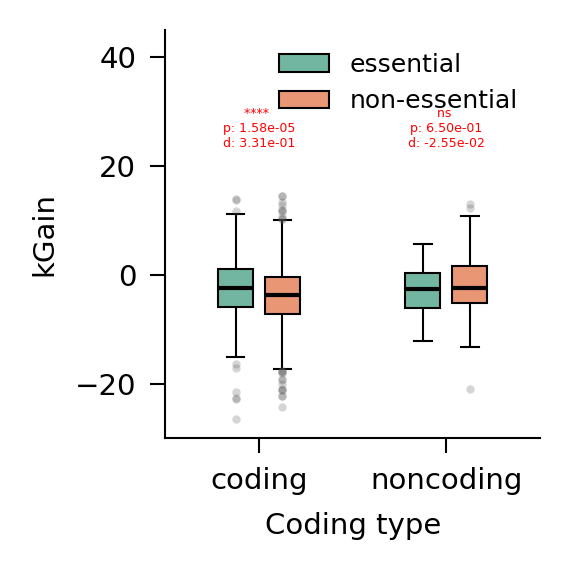

In [ ]:

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

fig, ax = plt.subplots(1,1, figsize = (2, 2), dpi =300)
type = "non_mutator"
data =None
data = kgain_mutations_annotated
data = data[data["mutator_type"]==type]
x_column = "coding_type"
y_column = "evolved_kGain"
hue_column= 'essentiality_status'
group1_name = "essential"
group2_name = "non-essential"
data.sort_values(hue_column, inplace=True)

ax = sns.boxplot(data=data, x=x_column, y= y_column, hue = hue_column,     fliersize=1,         # reduce outlier dot size
    linewidth=0.5,         # box line thickness
    width=0.5,  
    meanprops={"marker": "o",
               "markerfacecolor": "black",
               "markeredgecolor": "black",
               "markersize": "5"},
    medianprops={"color": "black", "linewidth": 1},   # <-- median line black & thickness 1
    boxprops={"edgecolor": "black"},                  # <-- box border color black
    whiskerprops={"color": "black"},                  # <-- whisker color black
    capprops={"color": "black"},                      # <-- cap (top/bottom line) color black
    palette="Set2",
    dodge=True,
    gap=0.25,
    flierprops=dict(marker='o', markersize=1, alpha=0.25)

)
ax = utility.return_box_with_p_effect_size(ax=ax, data = data, x_columns = x_column, y_columns = y_column, group1_name = group1_name, group2_name = group2_name, y_pos = 23.5,  fontsize=3, hue_columns=hue_column)
ax.set_ylabel("kGain")
ax.set_xlabel("Coding type")
ax = utility.custom_figure_axis(ax, fontsize= 7, rotation=0)
ax.legend(ncol = 1, frameon=False, fontsize= 6)
# Improve tick label font size and make sure ticks show
ax.tick_params(axis='x', which='both', labelsize=7, bottom=True, top=False, direction='out')
ax.tick_params(axis='y', which='both', labelsize=7, left=True, right=False, direction='out')
# ax.set_title(type, fontsize = 5)

ax.set_ylim(-30, 45)

plt.tight_layout()
# plt.savefig("kGain vs coding type for mutator.pdf", dpi =300)

##### fig. 3g

In [139]:
# kgain_mutations_annotated

P-value = 3.87e-02 and effect size = 7.38e-02 for coding,
P-value = 1.42e-01 and effect size = 7.99e-02 for noncoding,


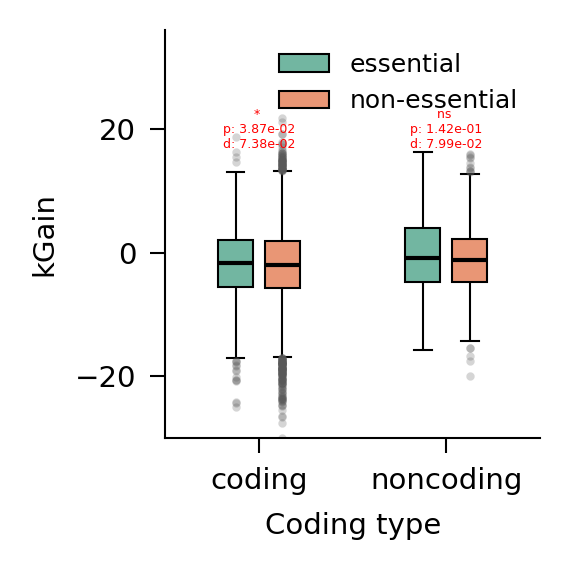

In [137]:

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

fig, ax = plt.subplots(1,1, figsize = (2, 2), dpi =300)
type = "mutator"
data =None
data = kgain_mutations_annotated
data = data[data["mutator_type"]==type]
# data["generation_number_bin"] = data["generation_number_bin"].astype(str)
x_column = "coding_type"
y_column = "evolved_kGain"
hue_column= 'essentiality_status'
group1_name = "essential"
group2_name = "non-essential"
data.sort_values(hue_column, inplace=True)

ax = sns.boxplot(data=data, x=x_column, y= y_column, hue = hue_column,     fliersize=1,         # reduce outlier dot size
    linewidth=0.5,         # box line thickness
    width=0.5,  
    meanprops={"marker": "o",
               "markerfacecolor": "black",
               "markeredgecolor": "black",
               "markersize": "5"},
    medianprops={"color": "black", "linewidth": 1},   # <-- median line black & thickness 1
    boxprops={"edgecolor": "black"},                  # <-- box border color black
    whiskerprops={"color": "black"},                  # <-- whisker color black
    capprops={"color": "black"},                      # <-- cap (top/bottom line) color black
    palette="Set2",
    dodge=True,
    gap=0.25,
    flierprops=dict(marker='o', markersize=1, alpha=0.25)
    # meanprops={"marker":"o",
    #            "markerfacecolor":"black",
    #            "markeredgecolor":"black",
    #            "markersize":"5"},
    # palette="Set2",
    # dodge=True,
    # gap = 0.25,

    # flierprops=dict(marker='o', markersize=1, alpha=0.25)
    # # fliersize=2 
)
ax = utility.return_box_with_p_effect_size(ax=ax, data = data, x_columns = x_column, y_columns = y_column, group1_name = group1_name, group2_name = group2_name, y_pos = 17,  fontsize=3, hue_columns=hue_column)
ax.set_ylabel("kGain")
ax.set_xlabel("Coding type")
ax = utility.custom_figure_axis(ax, fontsize= 7, rotation=0)
ax.legend(ncol = 1, frameon=False, fontsize= 6)
# Improve tick label font size and make sure ticks show
ax.tick_params(axis='x', which='both', labelsize=7, bottom=True, top=False, direction='out')
ax.tick_params(axis='y', which='both', labelsize=7, left=True, right=False, direction='out')
# ax.set_title(type, fontsize = 5)

ax.set_ylim(-30, 36)

plt.tight_layout()
plt.savefig("kGain vs coding type for mutator.pdf", dpi =300)

##### fig 3(h-k)

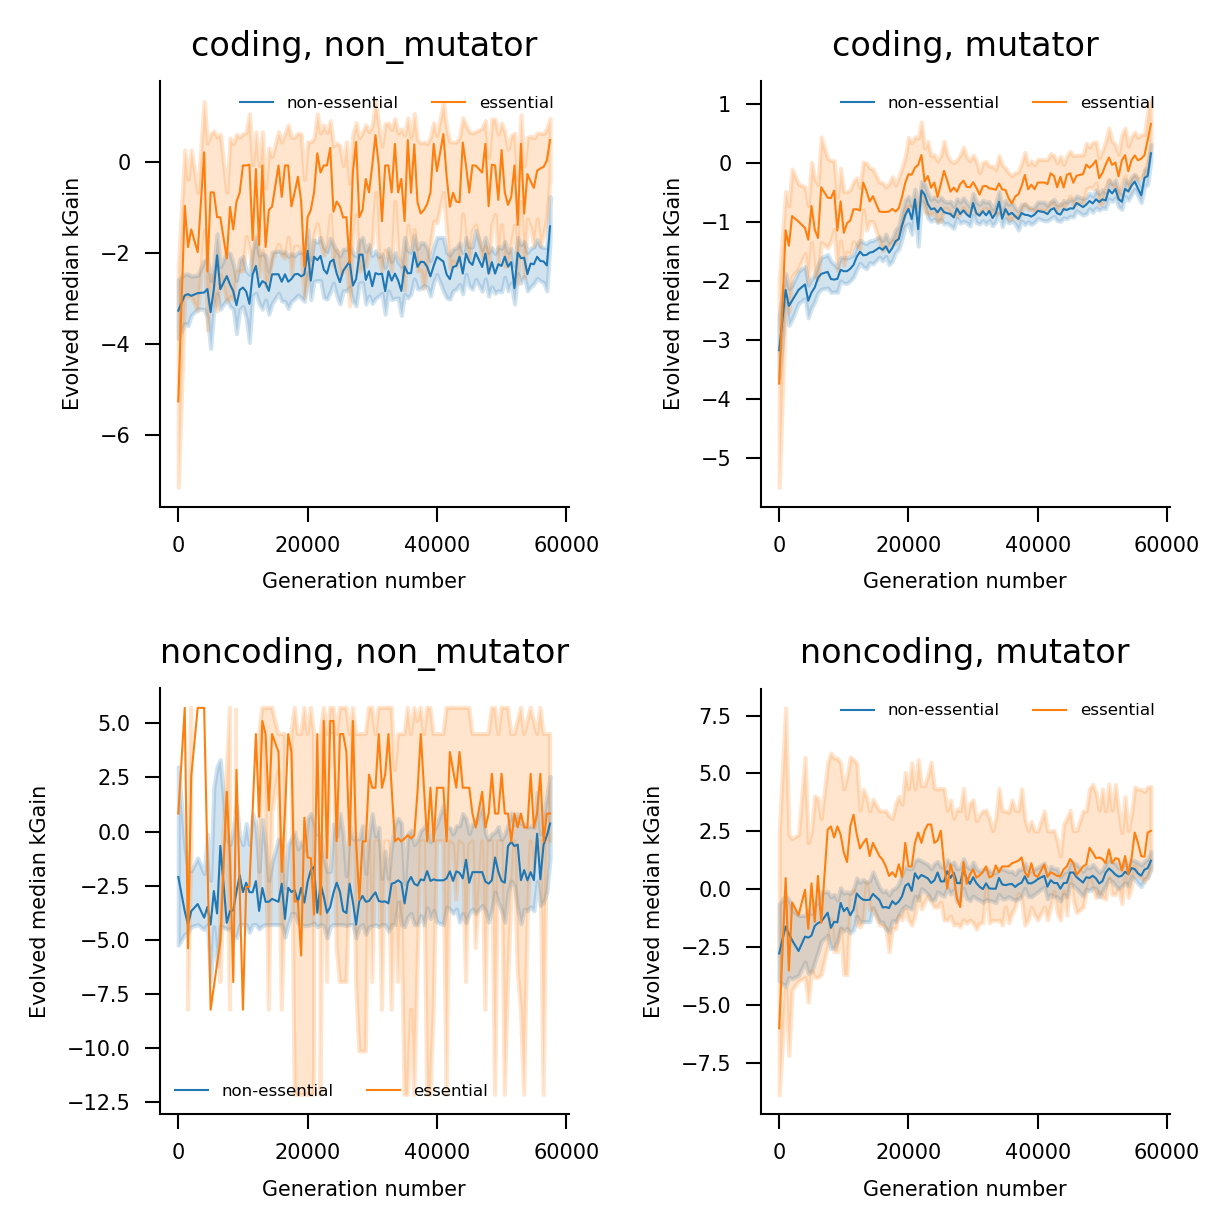

In [65]:
fig, ax = plt.subplots(2, 2, figsize=(4.2, 4.2), dpi=300)

coding_types = ["coding", "noncoding"]
mutator_types = ["non_mutator", "mutator"]

for i, coding_type_tmp in enumerate(coding_types):
    for j, mutator_type_tmp in enumerate(mutator_types):
        subset = mutation_with_essentiality_df[
            (mutation_with_essentiality_df["coding_type"] == coding_type_tmp) & 
            (mutation_with_essentiality_df["mutator_type"] == mutator_type_tmp)
        ]
        ax[i][j] = sns.lineplot(subset, x="generation_number", y="evolved_kGain",
                     hue="essentiality_status", ax=ax[i][j], lw=0.5, estimator='median')
        ax[i][j].set_xlabel("Generation number")
        ax[i][j].set_ylabel("Evolved median kGain")
        ax[i][j].set_title(f"{coding_type_tmp}, {mutator_type_tmp}", fontsize=8)
        ax[i][j] = utility.custom_figure_axis(ax[i][j], fontsize=5, rotation=0)
        ax[i][j] .legend(ncol = 2, fontsize=4, frameon=False)

plt.tight_layout()
plt.savefig("Evolved median kGain vs generation with mutator type and essentiality as hue.pdf", dpi = 300)